# **Trabalho de Ciência dos Dados: Análise de países**
*Guilherme de Mello Ferreira*

**País desenvolvido é país sem pobreza?**


Há o senso comum que um país desenvolvido é necessariamente rico. Pode-se dizer que esta afirmação está correta, porém em uma análise superficial. Uma simples pergunta já seria o bastante para quebrar a linha de racicínio desse pensamento inicial: *o que torna um país rico?* Algumas teorias já foram colocadas para tentar solver essa questão, como por exemplo, a campanha do Governo Federal Brasileiro durante os anos de mandato da ex-presidente Dilma Rousseff: *país rico é país sem pobreza.* que foi bastante contextada por parecer redundante. Porém, essa redundância existe de fato? Este trabalho propõe uma análise dessa situação, trazendo dados da desigualdade social presente em todo o mundo e mostrando se o IDH é de fato alterado por ela ou se as anomalias muito presentes na própria desigualdade são fundamentais para a elevação/queda do mesmo. Afinal, um país desenvolvido é um país sem pobreza? 

Para responder a essa pergunta, foram criados dois índices a partir dos dados existentes: o primeiro a ser considerado, leva em conta o PIB *per capta*, a razão de bilionários por 1 milhão e a porcentagem da população que vive com mnos de 1,25 USD por dia. O segundo, relaciona todos esses fatores com o índice de GINI, vendo a distribuição desse PIB contando suas desigualdades, de modo que: $S = \frac {PIB}{GINI}$, e comparando-a com os outros fatores.

Para iniciar a programação, importam-se as bibliotecas que serão utilizadas no processo:

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import math as math
from scipy import stats
import matplotlib.pyplot as plt



A seguir, lê-se os arquivos inicialmente em Excel, com os dados retirados do Gapminder, em ordem: IDH, índice Gini, PIB *per capta*, número de bilionários por 1M habitantes e percentual de pobreza.

In [2]:
dadosidh = pd.read_excel ('IDH.xlsx')
dadosgini = pd.read_excel ('gini.xlsx')
dadospib = pd.read_excel ('per capta.xlsx')
dadosbilionarios = pd.read_excel ('Bilionários.xlsx')
dadospobreza = pd.read_excel ('pobreza.xlsx')

Com isso, separa-se as colunas que representam o ano que será analisado, no caso, $2007$.

In [3]:
idh = dadosidh.loc[:,["HDI",2007]]
gini = dadosgini.loc [:,[2007]]
pib = dadospib.loc[:,[2007]]
bilionarios = dadosbilionarios.loc[:,[2007]]
pobreza = dadospobreza.loc[:,[2007]]

Em seguida, junta-se as três tabelas que comporão a primeira análise, que são: IDH, PIB *per capta* bilionários por milhão e pobreza

In [4]:
tabela = idh.join(pib, how ="inner", rsuffix=' PIB', lsuffix=' IDH')
tabela = tabela.join(bilionarios, how ="inner", rsuffix=' bi', lsuffix=' PIB')
tabela = tabela.join(pobreza, how ="inner", rsuffix=' pobres', lsuffix=' bi')

E retira-se os países que contém campos em branco, deixando a tabela mais limpa.

In [5]:
tabela.dropna()
tabela.columns = tabela.columns = ['País', 'IDH', 'PIB', 'Bilionários', 'Pobres']

As primeiras análises sairão dessa tabela, sem considerar o índice Gini. A seguir, insere-se na tabela tal índice, para fazer uma segunda análise.

Text(0.5,1,'Relação IDH x Pib per capta')

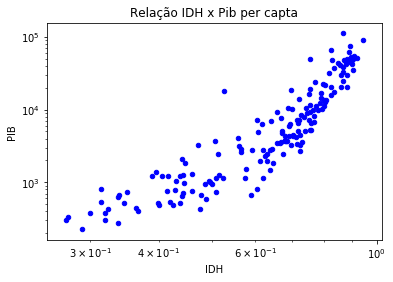

In [6]:
tabela.plot.scatter(x = "IDH", y = "PIB", loglog = True, color ='blue')
plt.title ('Relação IDH x Pib per capta')

Como podemos facilmente observar, existe uma clara correlação entre IDH e Pib *per capta* entre os países analisados.

count    258.000000
mean       0.249724
std        1.972028
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       30.608185
Name: Bilionários, dtype: float64

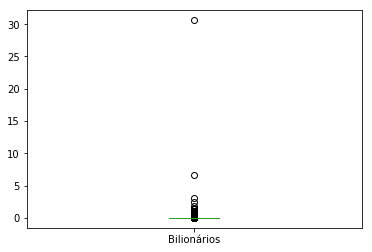

In [7]:
tabela.Bilionários.plot.box()
tabela.Bilionários.describe()

Podemos observar que a tabela de bilionários é repleta de anomalias, Uma vez que a maioria dos países não possui nenhuma pessoa nessa condição. As duas principais anomalias se tratam de Mônaco (com aproximadamente 30,6 bilionários por milhão de habitantes), pois o principado é conhecido por atrair grande fluxo de pessoas com muito dinheiro, devido aos seus casinos e aos setores imobiliário, que é muito forte em venda de imóveis de luxo, com muitas construtoras, e financeiro, uma vez que o país pe um paraíso fiscal, atraíndo grandes investidores; e Islândia, um país de cunho liberal, o que proporcionou um grande investimento externo no país, gerando um grande fluxo de dinheiro e enriquecimento rápido de um número relativamente grande de pessoas, considerando a população total do país (pouco mais de 300 000 habitantes).

Pelo _describe_ também podemos fazer uma primeira conclusão, bastante óbvia: mais de 75% dos países não possuem um bilionário sequer, chegando à uma primeira pergunta prévia: _Os países que possuem bilionários são, de fato, os mais desenvolvidos?_ Para respondê-la, fazer-se-á um isolamento dos países que possuem bilionários, excluíndo a maior anomalia: Mônaco. A Islândia não será retirada, pois sua população é considerável

In [19]:
a = tabela[tabela.Bilionários>0]

In [20]:
tabela["IDHBAR"] = pd.cut(tabela['IDH'], bins=10)
tabela['BilionáriosBar'] = pd.cut (a['Bilionários'], bins = 1)
cruzada = pd.crosstab(tabela["IDHBAR"], tabela["BilionáriosBar"])
cruzada

BilionáriosBar,"(-0.0217, 30.608]"
IDHBAR,
"(0.27, 0.338]",0
"(0.338, 0.405]",0
"(0.405, 0.472]",0
"(0.472, 0.539]",1
"(0.539, 0.606]",2
"(0.606, 0.674]",4
"(0.674, 0.741]",8
"(0.741, 0.808]",11
"(0.808, 0.875]",9


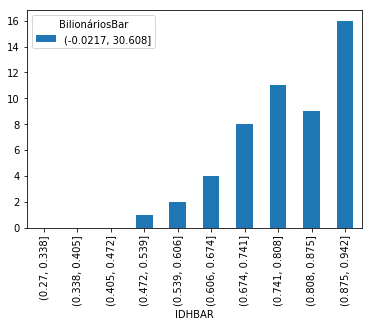

In [10]:
cruzada.plot.bar()

Pela análise da tabela e do gráfico, parece razoável supor que quanto mais desenvolvido um país é, maior a propensão a este possuir pelo menos um bilionário. Porém esses dados ainda não podem levar à uma conclusão parcial, pois não sabemos a quantidade de países que se encontram em cada uma das faixas. Por isso, analisar-se-á o percentual.

In [11]:
tabela["IDHBAR"] = pd.cut(tabela["IDH"], bins=10)
faixas =  tabela["IDHBAR"].value_counts(sort=False)
faixas.describe

<bound method NDFrame.describe of (0.27, 0.338]     12
(0.338, 0.405]     9
(0.405, 0.472]    17
(0.472, 0.539]    14
(0.539, 0.606]    10
(0.606, 0.674]    22
(0.674, 0.741]    28
(0.741, 0.808]    26
(0.808, 0.875]    18
(0.875, 0.942]    18
Name: IDHBAR, dtype: int64>

Faze-se o mesmo para o percentual de pobres.

count    55.000000
mean      1.467721
std       4.091085
min       0.000000
25%       0.017800
50%       0.128000
75%       1.060000
max      27.900000
Name: Pobres, dtype: float64

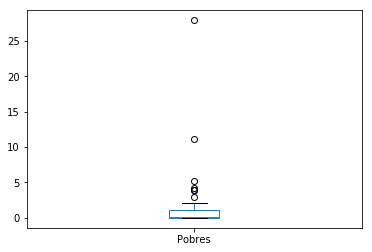

In [14]:
tabela.Pobres.plot.box()
tabela.Pobres.describe()

Novamente vemos daus anomalias bastante claras: Tanzânia (com aproximadamente 27,9% da população recebendo menos de $1,25 por dia) e Brasil

In [12]:
#Boxplot pobreza e bilionários para cada faixa de IDH.

In [13]:
tabela = tabela.join(gini, how ="inner", rsuffix='2007 gini')
tabela.dropna()
tabela.drop('IDHBAR')

ValueError: labels ['IDHBAR'] not contained in axis

In [ ]:
tabela.columns = ['País', 'IDH', 'PIB', 'Bilionários', 'Pobres', 'Gini']

In [ ]:
tabela.fillna(0)

In [ ]:
tabela.plot.scatter(x = "IDH", y = "Gini", loglog = True, color = 'b')
plt.title ('Relação IDH x índice Gini')

In [ ]:
tabela.plot.scatter(x = "PIB", y = "Gini", loglog = True, color = 'b')
plt.title ('Relação IDH x índice Gini')

In [ ]:
S = tabela.PIB/tabela.Gini.dropna()
tabela ['S'] = S
tabela

In [ ]:
tabela.plot.scatter(x = "IDH", y = "S", loglog = True, color = 'c')
plt.title ('Relação IDH x índice S')

In [ ]:
#assim, concluímos que um país desenvolvido é de fato país sem pobreza, porém, o mesmo não se diz sobre a desigualdade